In [672]:
%run constants.ipynb
%run dataloaders.ipynb
%run utils.ipynb
%run models.ipynb
%run coresets.ipynb
%run train_and_test.ipynb
%run config.ipynb

In [673]:
def run_experiment_for(model, print_progress=False):
    config = model.config
    dataloaders = config.dataloaders
    coreset_alg = config.coreset_alg
    assert coreset_alg is None or coreset_alg.coresets == []  # should initially be empty
    results = np.zeros((len(config.tasks), len(config.tasks)))
    results_std = np.zeros((len(config.tasks), len(config.tasks)))
    is_vcl = isinstance(model, VCLNN)
    
    # Train and evaluate
    for task_id in range(len(config.tasks)):
        print_if(f"\nTraining on Task {task_id+1} ...", print_progress)
        train_loader, _ = dataloaders[task_id]
        # Train on non-coreset data
        train(model, train_loader, task_id)
        print_if(f"... Finished training on Task {task_id+1}", print_progress)
        
        # Train on new coreset
        if is_vcl and coreset_alg is not None and config.coreset_size > 0:  # VCL models with coresets
            coreset_alg.add_coreset(train_loader)
            # Train on coresets from previous tasks
            for prev_task in range(task_id+1):
                print_if(f"\nRe-training on Task {prev_task+1} ...", print_progress)
                train(model, coreset_alg.coresets[prev_task], prev_task)
        print_if('', print_progress)
        
        # Evaluate on previous tasks
        for curr_t in range(task_id+1):
            _, test_loader = dataloaders[curr_t]
            score, std = test(model, test_loader, curr_t, ret_std=True)
            print_if(f"Task {(curr_t+1):2d}  {config.eval_metric}: \
                        {np.round(score, 4):0.4f} ± {np.round(std, 4):0.4f}", print_progress)
            results[task_id, curr_t] = score
            results_std[task_id, curr_t] = std
        print_if('', print_progress)

        if is_vcl and config.update_prior:  # update prior for VCL models
            model.update_priors()
            
    return results, results_std

In [674]:
def run_experiment_multi(configs=None, task_type='classification', config_filter=None,
                         init_prior_scale=0.1, coreset_sizes=[50,100,200], 
                         print_progress=False, ret_std=True, show_vanilla=True):
    """Run complete VCL experiment"""
    if configs is None:
        configs = get_all_configs(task_type, config_filter,
                                  init_prior_scale, coreset_sizes)
    # Initialize models
    models = {c.name: VCLNN(c).to(DEVICE) for c in configs}
    if show_vanilla:
        vanillaNN = VanillaNN(ExperimentConfig()).to(DEVICE) 
        models[VANILLA_MODEL] = vanillaNN

    results = {}
    results_std = {}
    for model_name, model in models.items():
        res, res_std = run_experiment_for(model, print_progress=print_progress)
        results[model_name] = res
        results_std[model_name] = res_std
    return results if not ret_std else (results, results_std)

# Results

In [675]:
%run utils.ipynb

## Classification

In [676]:
torch.manual_seed(7)
np.random.seed(7)
configs = get_all_configs('classification')
cla_all_results, cla_all_std = run_experiment_multi(configs=configs, task_type='classification')

In [677]:
cla_all_results

{'GaussianVCL (Random, 200)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.88107812, 0.        , 0.        , 0.        ],
        [0.99956597, 0.89813282, 0.90516625, 0.        , 0.        ],
        [0.99956597, 0.93192969, 0.92872284, 0.98765706, 0.        ],
        [0.99956597, 0.89816797, 0.95105278, 0.99267578, 0.89789809]]),
 'ExpVCL (Kcenter, 50)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.83792187, 0.        , 0.        , 0.        ],
        [0.99956597, 0.73799609, 0.90028344, 0.        , 0.        ],
        [0.99913194, 0.903875  , 0.89288776, 0.89680151, 0.        ],
        [0.99913194, 0.86421875, 0.91511052, 0.9626188 , 0.86515257]]),
 'GaussianVCL (Random, 100)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.96229687, 0.        , 0.        , 0.        ],
        [0.99956597, 0.96130859, 0.96063977, 0.        , 0.        ],
    

### Aggregated results for models using random coresets of size 200

In [678]:
# Mean lifetime test accuracies
mean_aggr_results(cla_all_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: 'Random, 200' in m or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.9436543184436029,
  'ExpVCL (Random, 200)': 0.9485845280852583,
  'Vanilla': 0.9709746509542068},
 {'GaussianVCL (Random, 200)': 0.04318884627008079,
  'ExpVCL (Random, 200)': 0.047802208953406304,
  'Vanilla': 0.02964211228512102})

In [679]:
# Mean final test accuracies
mean_aggr_results(cla_all_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: ('Random, 200' in m) or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.9478721198108462,
  'ExpVCL (Random, 200)': 0.9515611698230106,
  'Vanilla': 0.9419272881415155},
 {'GaussianVCL (Random, 200)': 0.04394916423003002,
  'ExpVCL (Random, 200)': 0.04732741292191606,
  'Vanilla': 0.065248725665469})

### Plots

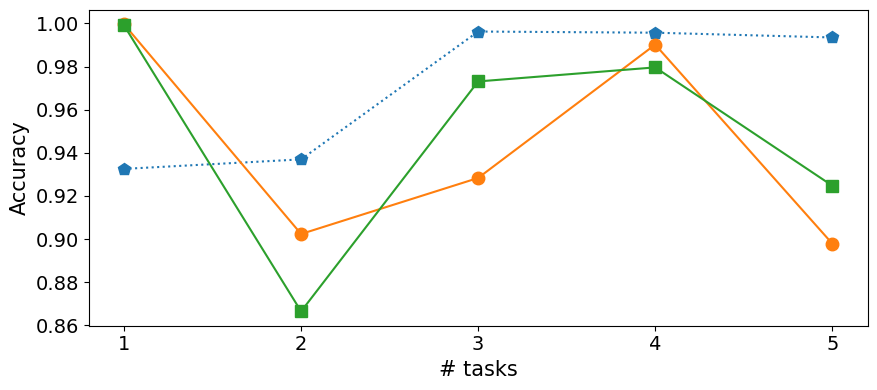

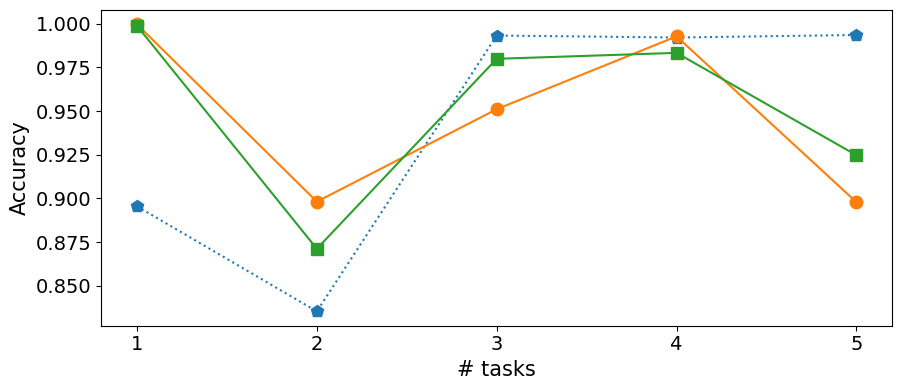

In [680]:
%run utils.ipynb
plot_mean_results(ExperimentConfig(task_type='classification'), cla_all_results, 
                  mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)
plot_final_results(ExperimentConfig(task_type='classification'), cla_all_results, 
                   mname_filter=(lambda m : 'Random, 200' in m  or m == VANILLA_MODEL),
                   loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)

## Regression

In [681]:
torch.manual_seed(7)
np.random.seed(7)
configs = get_all_configs('regression')
reg_all_results, reg_all_std = run_experiment_multi(configs=configs, task_type='regression')

### Aggregated results for models using random coresets of size 200

In [682]:
# Mean lifetime test RMSEs
mean_aggr_results(reg_all_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: ('Random' in m and '200' in m) or 'None' in m or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.19384974821574158,
  'ExpVCL (Random, 200)': 0.32276403178357416,
  'ExpVCL (None)': 0.35840433286296,
  'GaussianVCL (None)': 0.20668415745513308,
  'Vanilla': 0.9766650568279955},
 {'GaussianVCL (Random, 200)': 0.037102577705630926,
  'ExpVCL (Random, 200)': 0.04909580610921902,
  'ExpVCL (None)': 0.1145855567146258,
  'GaussianVCL (None)': 0.028995462848403996,
  'Vanilla': 0.021517007460117827})

In [683]:
# Mean final test RMSEs
mean_aggr_results(reg_all_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: ('Random' in m and '200' in m) or 'None' in m or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.2089925473762883,
  'ExpVCL (Random, 200)': 0.3443803839799431,
  'ExpVCL (None)': 0.4189097077896197,
  'GaussianVCL (None)': 0.2341557080960936,
  'Vanilla': 0.9660499736666679},
 {'GaussianVCL (Random, 200)': 0.03642683627349159,
  'ExpVCL (Random, 200)': 0.07225716867173058,
  'ExpVCL (None)': 0.167032313570185,
  'GaussianVCL (None)': 0.031972553913910774,
  'Vanilla': 0.03782142836039536})

### Plots

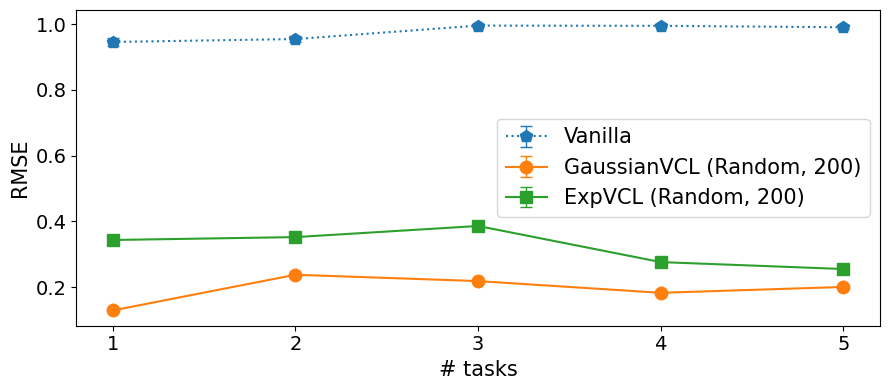

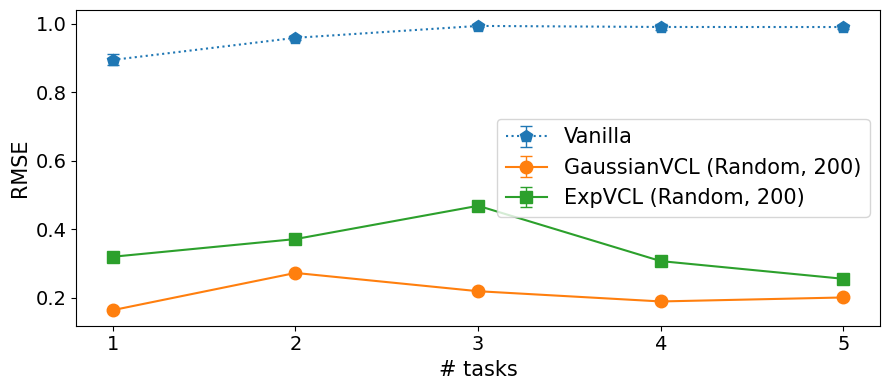

In [684]:
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                 loc=None, bbox_to_anchor=None, figsize=(9,4))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,4))

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\s'
/var/folders/tk/2zq7clf94gx3rdh5slf6rhc00000gn/T/ipykernel_34171/3703677406.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, normal_pdf, label=f'Normal($\mu$={mu}, $\sigma$={sigma})', linewidth=2)
/var/folders/tk/2zq7clf94gx3rdh5slf6rhc00000gn/T/ipykernel_34171/3703677406.py:34: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, normal_pdf, label=f'Normal($\mu$={mu}, $\sigma$={sigma})', linewidth=2)


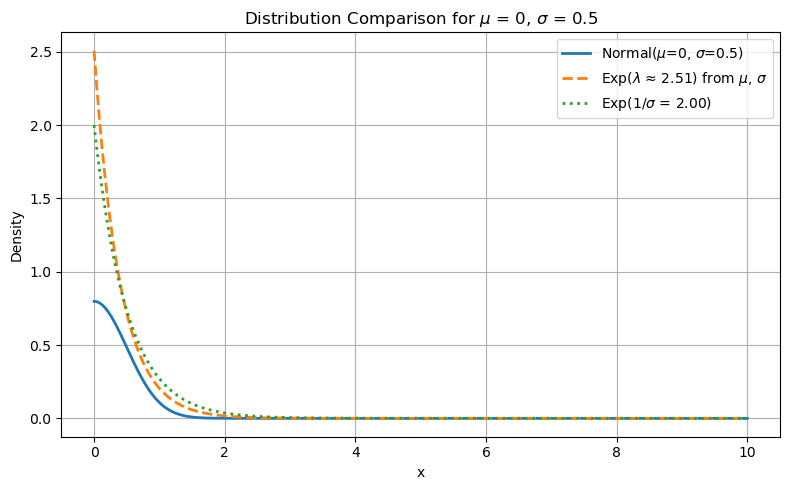

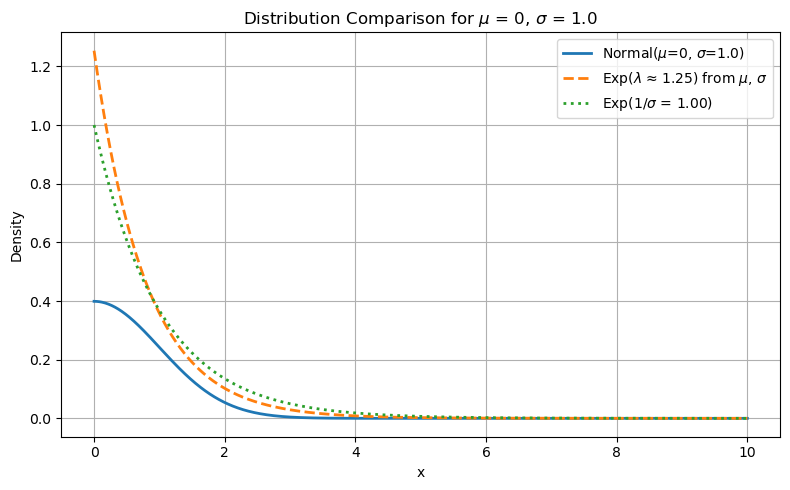

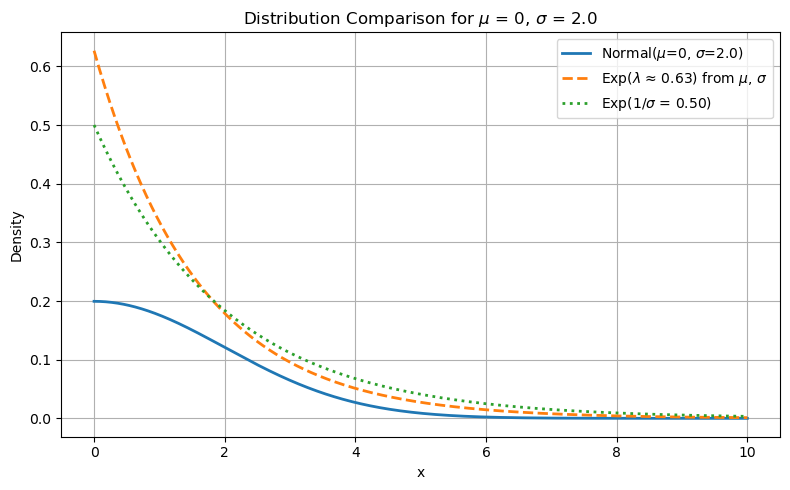

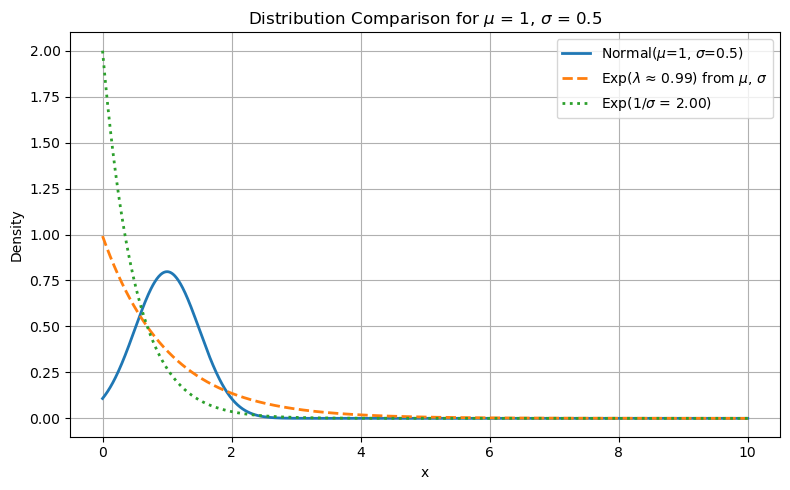

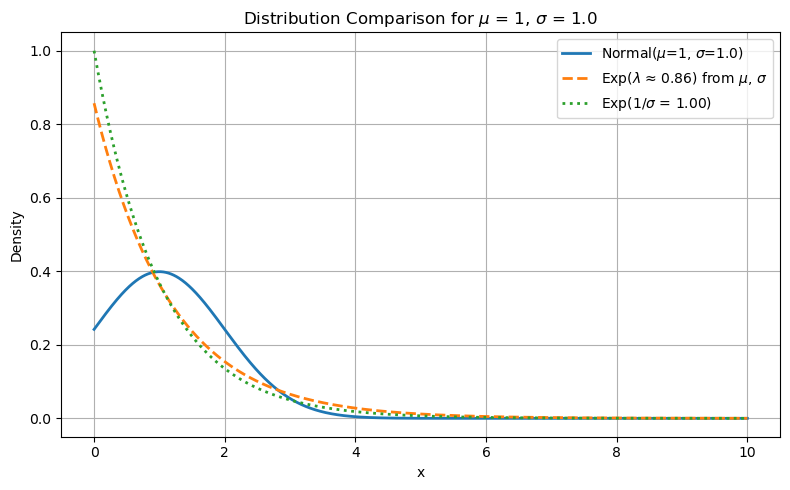

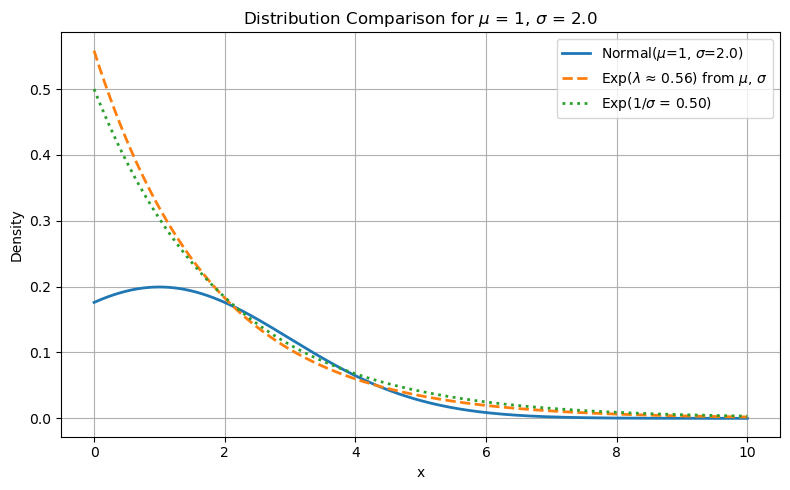

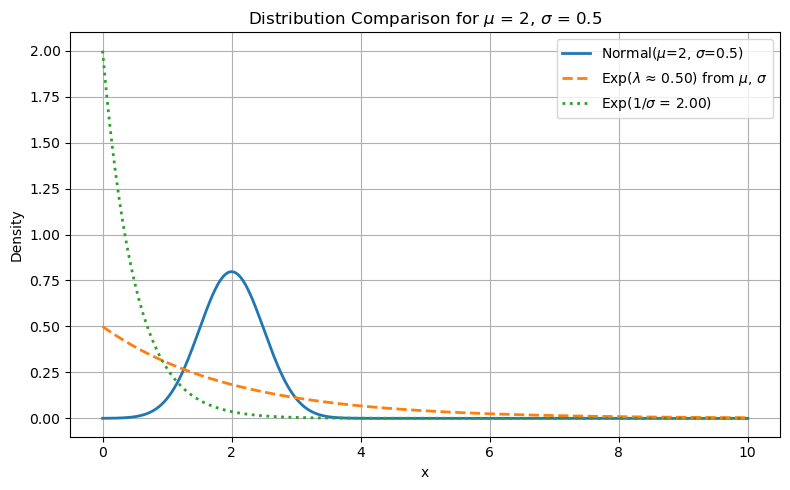

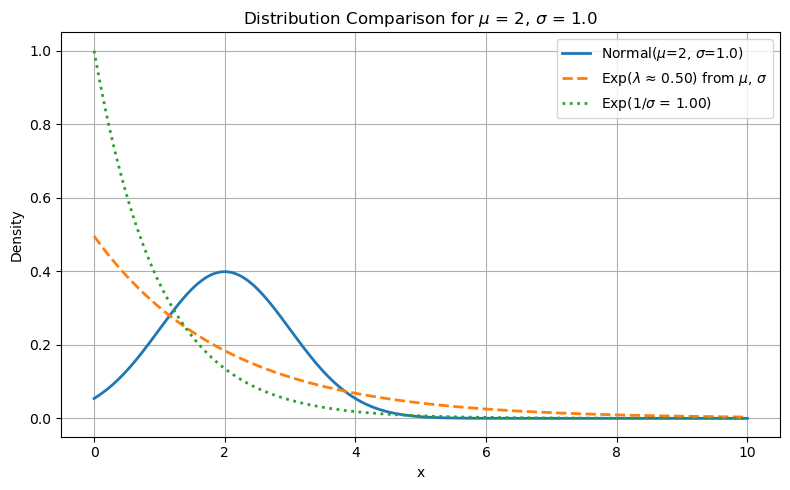

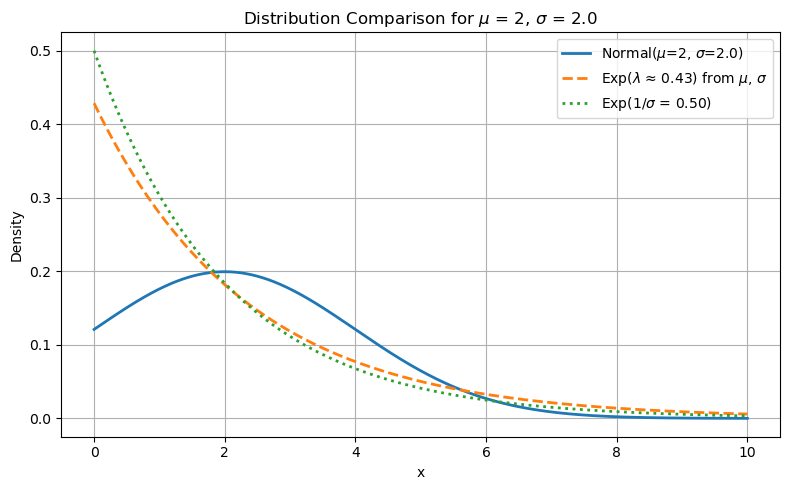

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

def compute_lambda(mu, sigma):
    z = -mu / sigma
    phi = norm.cdf(z)
    lambda_inv = sigma * np.sqrt(2 / np.pi) * np.exp(-mu**2 / (2 * sigma**2)) + mu * (1 - 2 * phi)
    return 1. / lambda_inv

# Set of (mu, sigma) to explore
mu_values = [0, 1, 2]
sigma_values = [0.5, 1.0, 2.0]

# Range of x values (positive only)
x = np.linspace(0, 10, 1000)

# Loop over each (mu, sigma) pair and plot on the same axes
for mu in mu_values:
    for sigma in sigma_values:
        plt.figure(figsize=(8, 5))

        # Normal distribution
        normal_pdf = norm.pdf(x, loc=mu, scale=sigma)

        # Exponential distribution with lambda derived from truncated normal mean
        lambda_val = compute_lambda(mu, sigma)
        exp_lambda_pdf = expon.pdf(x, scale=1 / lambda_val)

        # Exponential with scale = sigma
        exp_sigma_pdf = expon.pdf(x, scale=sigma)

        # Plot all on same axis
        plt.plot(x, normal_pdf, label=f'Normal($\mu$={mu}, $\sigma$={sigma})', linewidth=2)
        plt.plot(x, exp_lambda_pdf, '--', label=fr'Exp($\lambda$ ≈ {lambda_val:.2f}) from $\mu$, $\sigma$', linewidth=2)
        plt.plot(x, exp_sigma_pdf, ':', label=fr'Exp(1/$\sigma$ = {1/sigma:.2f})', linewidth=2)

        plt.title(fr'Distribution Comparison for $\mu$ = {mu}, $\sigma$ = {sigma}')
        plt.xlabel('x')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Results

In [567]:
%run utils.ipynb

## Classification

In [503]:
torch.manual_seed(7)
np.random.seed(7)
configs = get_all_configs('classification')
cla_all_results, cla_all_std = run_experiment_multi(configs=configs, task_type='classification')

In [624]:
cla_all_results

{'GaussianVCL (Random, 200)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.88107812, 0.        , 0.        , 0.        ],
        [0.99956597, 0.89813282, 0.90516625, 0.        , 0.        ],
        [0.99956597, 0.93192969, 0.92872284, 0.98765706, 0.        ],
        [0.99956597, 0.89816797, 0.95105278, 0.99267578, 0.89789809]]),
 'ExpVCL (Kcenter, 50)': array([[0.99913194, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.90799218, 0.        , 0.        , 0.        ],
        [0.99956597, 0.92558203, 0.88233612, 0.        , 0.        ],
        [1.        , 0.92157032, 0.88636147, 0.96845804, 0.        ],
        [0.99956597, 0.92890625, 0.90333222, 0.98503947, 0.85800474]]),
 'GaussianVCL (Random, 100)': array([[0.99956597, 0.        , 0.        , 0.        , 0.        ],
        [0.99956597, 0.96229687, 0.        , 0.        , 0.        ],
        [0.99956597, 0.96130859, 0.96063977, 0.        , 0.        ],
    

### Aggregated results for models using random coresets of size 200

In [625]:
# Mean lifetime test accuracies
mean_aggr_results(cla_all_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: 'Random, 200' in m or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.9436543184436029,
  'ExpVCL (Random, 200)': 0.9623816622793674,
  'Vanilla': 0.9709746509542068},
 {'GaussianVCL (Random, 200)': 0.04318884627008079,
  'ExpVCL (Random, 200)': 0.026667530383249226,
  'Vanilla': 0.02964211228512102})

In [628]:
# Mean final test accuracies
mean_aggr_results(cla_all_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: ('Random, 200' in m) or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.9478721198108462,
  'ExpVCL (Random, 200)': 0.9672024523218472,
  'Vanilla': 0.9419272881415155},
 {'GaussianVCL (Random, 200)': 0.04394916423003002,
  'ExpVCL (Random, 200)': 0.028228342821978343,
  'Vanilla': 0.065248725665469})

### Plots

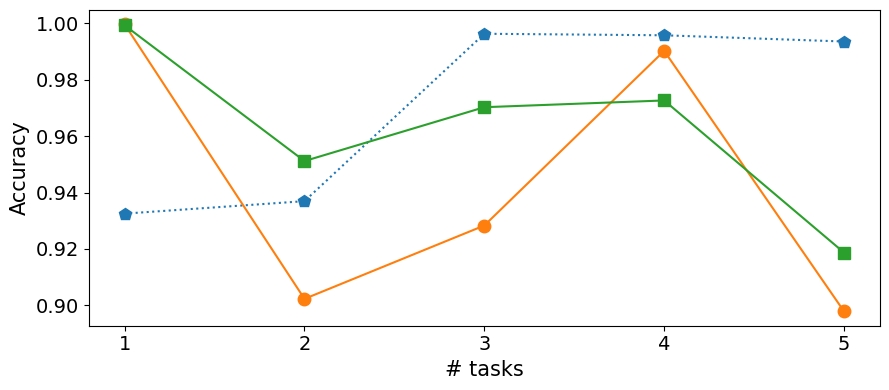

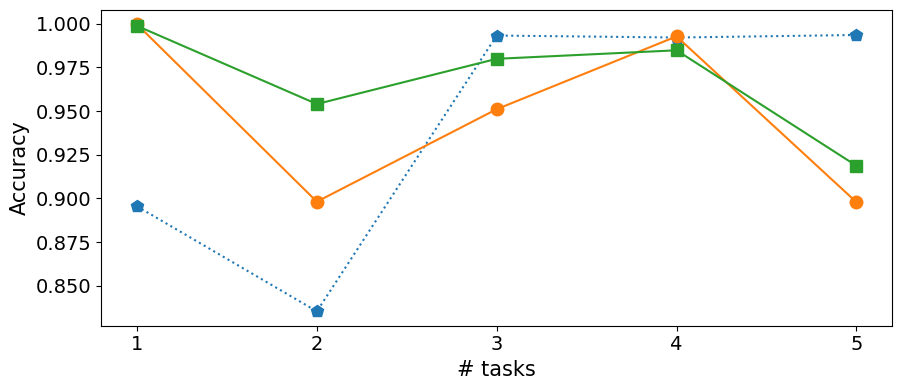

In [666]:
%run utils.ipynb
plot_mean_results(ExperimentConfig(task_type='classification'), cla_all_results, 
                  mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)
plot_final_results(ExperimentConfig(task_type='classification'), cla_all_results, 
                   mname_filter=(lambda m : 'Random, 200' in m  or m == VANILLA_MODEL),
                   loc=None, bbox_to_anchor=None, figsize=(9,4), legend=False)

## Regression

In [504]:
torch.manual_seed(7)
np.random.seed(7)
configs = get_all_configs('regression')
reg_all_results, reg_all_std = run_experiment_multi(configs=configs, task_type='regression')

### Aggregated results for models using random coresets of size 200

In [630]:
# Mean lifetime test RMSEs
mean_aggr_results(reg_all_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: ('Random' in m and '200' in m) or 'None' in m or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.19384974821574158,
  'ExpVCL (Random, 200)': 0.3175080461965667,
  'ExpVCL (None)': 0.35634412455889913,
  'GaussianVCL (None)': 0.20668415745513308,
  'Vanilla': 0.9766650568279955},
 {'GaussianVCL (Random, 200)': 0.037102577705630926,
  'ExpVCL (Random, 200)': 0.0294831037240813,
  'ExpVCL (None)': 0.12264388300527179,
  'GaussianVCL (None)': 0.028995462848403996,
  'Vanilla': 0.021517007460117827})

In [631]:
# Mean final test RMSEs
mean_aggr_results(reg_all_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: ('Random' in m and '200' in m) or 'None' in m or m == VANILLA_MODEL))

({'GaussianVCL (Random, 200)': 0.2089925473762883,
  'ExpVCL (Random, 200)': 0.3259361535310745,
  'ExpVCL (None)': 0.4492127918120888,
  'GaussianVCL (None)': 0.2341557080960936,
  'Vanilla': 0.9660499736666679},
 {'GaussianVCL (Random, 200)': 0.03642683627349159,
  'ExpVCL (Random, 200)': 0.042102306660063454,
  'ExpVCL (None)': 0.22042531905849652,
  'GaussianVCL (None)': 0.031972553913910774,
  'Vanilla': 0.03782142836039536})

### Plots

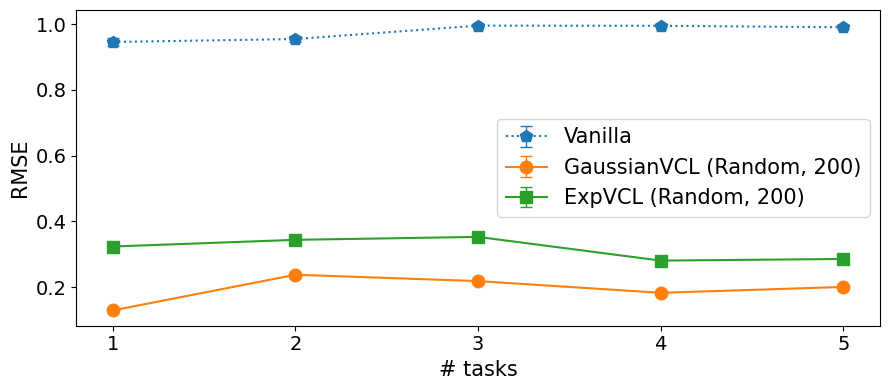

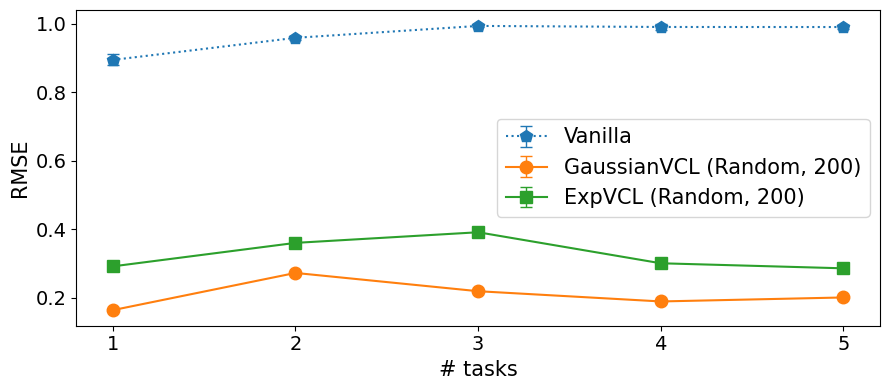

In [665]:
plot_mean_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                 mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                 loc=None, bbox_to_anchor=None, figsize=(9,4))
plot_final_results(ExperimentConfig(task_type='regression'), reg_all_results, results_std=reg_all_std,
                  mname_filter=(lambda m : 'Random, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,4))

## Optionally Import & Export Results

In [647]:
# export results
export_results(cla_all_results, 'classification', datatype='mean')
export_results(cla_all_std, 'classification', datatype='std')
export_results(reg_all_results, 'regression', datatype='mean')
export_results(reg_all_std, 'regression', datatype='std')

In [ ]:
# import results
cla_all_results = import_results('classification', datatype='mean')
cla_all_std = import_results('classification', datatype='std')
reg_all_results = import_results('regression', datatype='mean')
reg_all_std = import_results(reg_all_std, 'regression', datatype='std')